In [1]:
import distribution_test as dt
import numpy as np
import pandas as pd

In [2]:
with open('../../postprocessing/representation.npy', 'rb') as f:
    rep = np.load(f)
    
df = pd.read_csv('../../dataset/m_test.csv')
print(df.columns.values)

['object_id' 'photoz' 'petroR90_r' 'r_cmodel_mag_ge' 'g_cmodel_mag_ge'
 'i_cmodel_mag_ge' 'z_cmodel_mag_ge' 'image_path' 'petro_half_light'
 'petro_90_light' 'dataset' 'snapshot_id' 'subhalo_id'
 'root_descendant_id' 'lookback' 'z' 'stellar_age_2rhalf_lumw'
 'fraction_disk_stars' 'stellar_mass' 'mass_in_rad' 'mass_exsitu'
 'half_mass_rad_physical' 'snap_num_last_maj_merger'
 'mass_last_maj_merger' 'mean_merger_lookback_time'
 'mean_merger_mass_ratio' 'color' 'i_band_mag_dust_apparent' 'mass'
 'lookback_time_last_maj_merger' 'exsitu']


In [35]:
indices_HSC = np.argwhere((df['dataset'] == 'HSC').to_numpy())[:,0]
indices_TNG100 = np.argwhere((df['dataset'] == 'HSC_TNG100').to_numpy())[:,0]

first_rep = rep[0]
first_df = df.iloc[0]

print(first_rep)
print(first_df)

np.random.shuffle(indices_HSC)
np.random.shuffle(indices_TNG100)

split_indices_HSC = np.array_split(indices_HSC, 2)
split_indices_TNG100 = np.array_split(indices_TNG100, 2)

x_list = [rep[split_indices_HSC[0]], rep[split_indices_HSC[1]], rep[split_indices_TNG100[0]], rep[split_indices_TNG100[1]]]
df_list = [df.iloc[split_indices_HSC[0]], df.iloc[split_indices_HSC[1]], df.iloc[split_indices_TNG100[0]], df.iloc[split_indices_TNG100[1]]]

x_list, df_list = dt.DistributionTest.reshape_inputs(x_list,df_list)
rep_HSC_0 = x_list[0]
rep_HSC_1 = x_list[1]
rep_TNG100_0 = x_list[2]
rep_TNG100_1 = x_list[3]
df_HSC_0 = df_list[0]
df_HSC_1 = df_list[1]
df_TNG100_0 = df_list[2]
df_TNG100_1 = df_list[3]

#print(np.sum(df_HSC_1['object_id'] == 40168200599522096.0))
#print(rep_HSC_1[df_HSC_1['object_id'] == 40168200599522096.0])

assert rep_HSC_0.shape[0] == len(df_HSC_0)
assert rep_HSC_1.shape[0] == len(df_HSC_1)
assert rep_TNG100_0.shape[0] == len(df_TNG100_0)
assert rep_TNG100_1.shape[0] == len(df_TNG100_1)

[ 6.6357e-01  4.9219e-01 -5.4590e-01 -1.0840e+00 -5.5029e-01  1.5332e-01
 -2.4796e-02  1.4368e-01 -7.1526e-07 -1.3867e-01 -2.3511e-01 -3.5791e-01
 -8.6719e-01 -2.0728e-01 -1.0944e-01 -3.3569e-04 -5.1953e-01 -5.6152e-01
  8.6279e-01 -7.8320e-01 -5.1270e-01 -1.1006e+00 -4.4263e-01 -4.7852e-01
  8.7451e-01  7.3608e-02 -5.5859e-01 -2.3755e-01 -1.9800e-01  1.1709e+00
 -3.4033e-01 -3.8867e-01  3.4888e-01  8.7549e-01 -3.7207e-01 -1.8591e-01
 -1.0986e+00 -3.0444e-01  7.1777e-01 -8.6689e-04 -5.0049e-01 -5.7910e-01
 -9.6741e-02  1.8848e-01 -1.1006e+00  2.2400e-01  0.0000e+00 -4.4800e-01
 -2.9077e-01  4.7339e-01  2.8589e-01  1.9141e-01 -9.5886e-02 -2.5757e-01
 -5.7959e-01 -7.6562e-01 -3.3057e-01 -8.9645e-04 -4.1840e-02 -2.0776e-01
 -1.0614e-01 -1.4748e-02 -4.1797e-01 -1.7242e-02 -2.1045e-01  5.5908e-02
  2.8027e-01 -7.9980e-01 -4.4067e-01 -2.1411e-01  4.8096e-02 -5.8545e-01
 -1.2573e-01 -1.3403e-01 -8.9746e-01 -1.0547e+00  0.0000e+00  6.0205e-01
 -2.3496e-04 -4.6730e-03 -6.5527e-01 -2.3392e-02  0

In [36]:
#mndd = dt.MeanNeighborDistanceDeviation(rep_HSC_0)
#measure = mndd.get_deviations(rep_TNG100_0)

mndd = dt.MeanNormalizedNeighborDistance(rep_TNG100_0, n_neighbor=8, p=1)
measure_HSC = mndd.get_normalized_neighbor_distances(rep_HSC_0)
measure_TNG = mndd.get_normalized_neighbor_distances(rep_TNG100_1)

#mndd = dt.MeanNeighborDistance(rep_HSC_0, n_neighbor=8, p=1)
#measure_HSC = mndd.get_distances(rep_HSC_1)
#measure_TNG = mndd.get_distances(rep_TNG100_0)

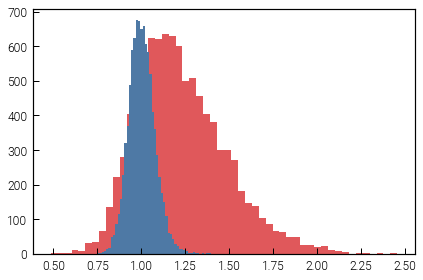

In [56]:
import matplotlib.pyplot as plt

plt.hist(measure_HSC, bins=50)
plt.hist(measure_TNG, bins=50)

plt.show()

max_HSC = np.max(measure_HSC)
min_HSC = np.min(measure_HSC)

mean_TNG = np.mean(measure_TNG)
std_TNG = np.std(measure_TNG)
lower_TNG = mean_TNG - std_TNG
upper_TNG = mean_TNG + std_TNG

[0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
9485   NaN
9486   NaN
9487   NaN
9488   NaN
9489   NaN
Name: object_id, Length: 9490, dtype: float64] contains non-finite values.
[0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
9485   NaN
9486   NaN
9487   NaN
9488   NaN
9489   NaN
Name: photoz, Length: 9490, dtype: float64] contains non-finite values.
[0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
9485   NaN
9486   NaN
9487   NaN
9488   NaN
9489   NaN
Name: petroR90_r, Length: 9490, dtype: float64] contains non-finite values.
[0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
9485   NaN
9486   NaN
9487   NaN
9488   NaN
9489   NaN
Name: r_cmodel_mag_ge, Length: 9490, dtype: float64] contains non-finite values.
[0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
9485   NaN
9486   NaN
9487   NaN
9488   NaN
9489   NaN
Name: g_cmodel_mag_ge, Length: 9490, dtype: float64] contains non-finite values.
[0   

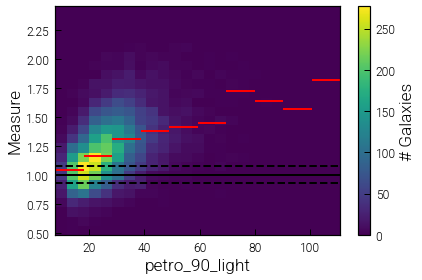

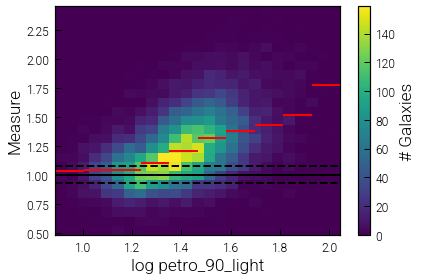

ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''


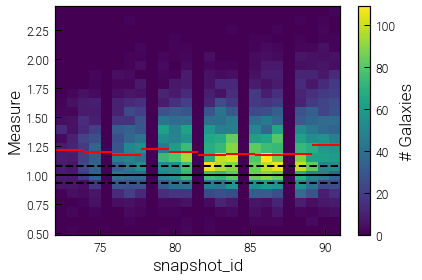

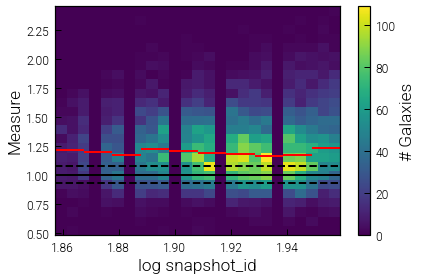

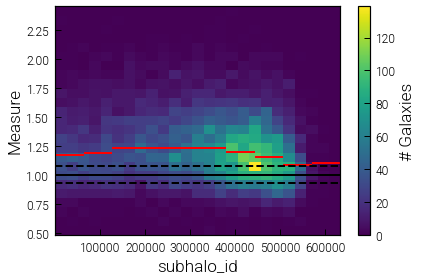

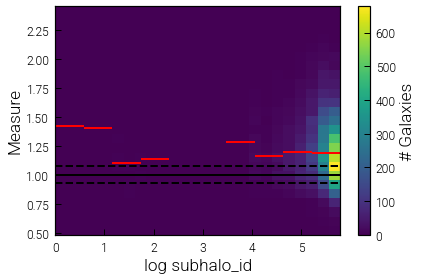

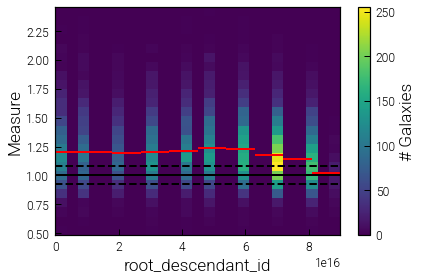

[0       16.602060
1       16.903091
2       16.477121
3       16.845098
4       16.000000
          ...    
9485    16.778151
9486    16.602060
9487    16.903090
9488    16.000000
9489    16.698970
Name: root_descendant_id, Length: 9490, dtype: float64] contains non-finite values.


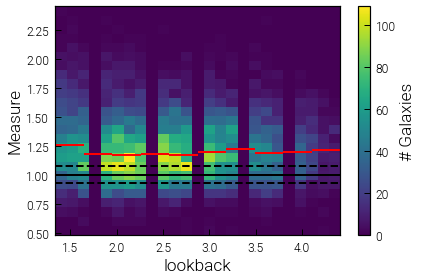

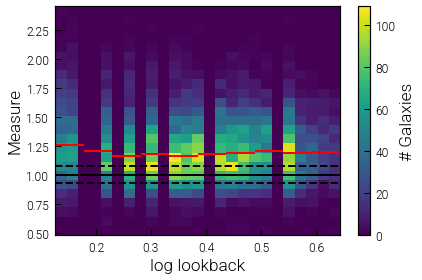

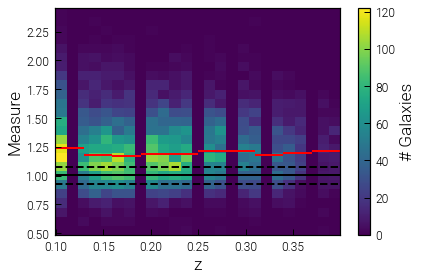

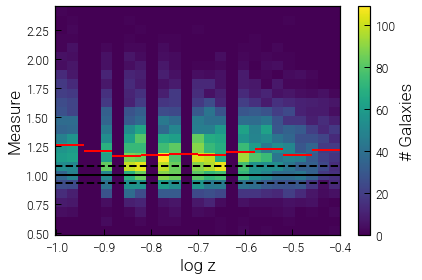

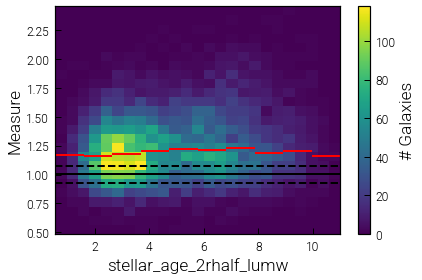

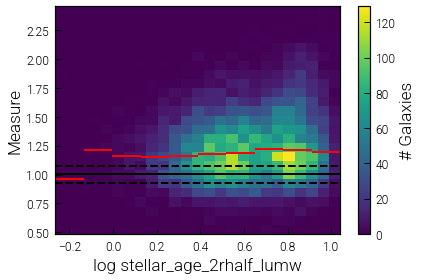

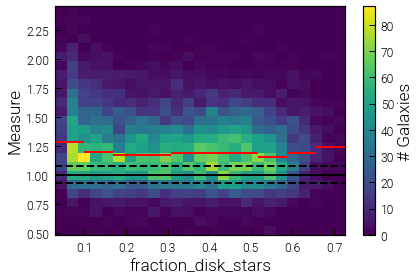

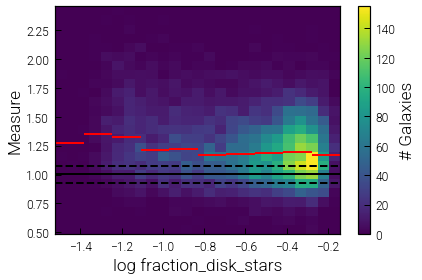

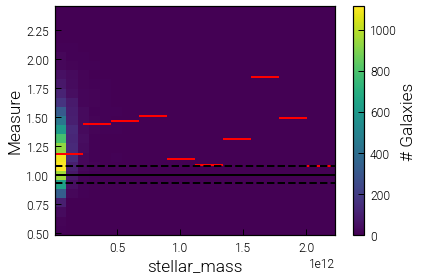

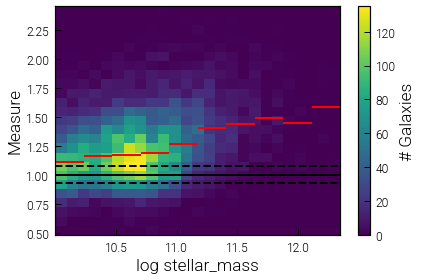

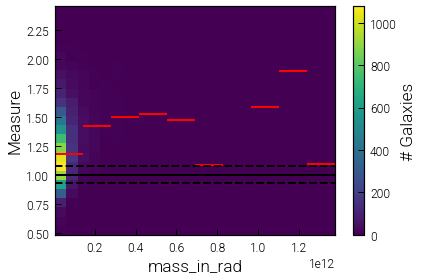

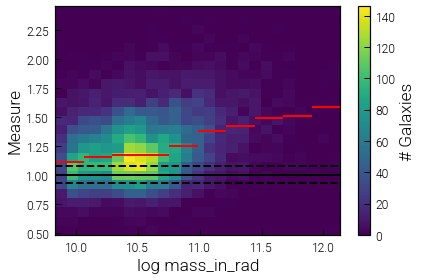

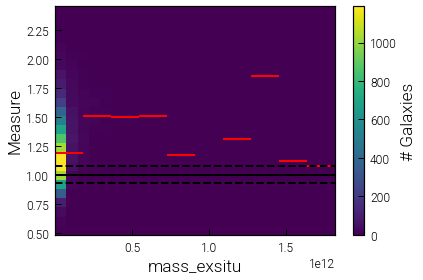

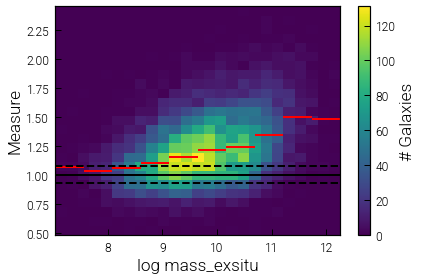

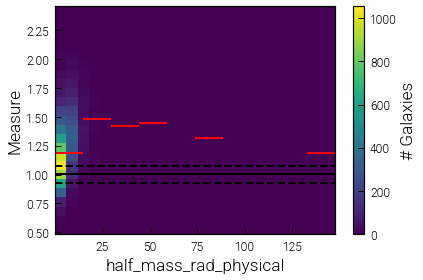

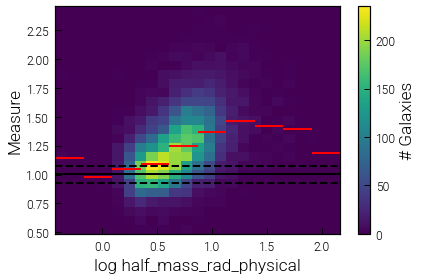

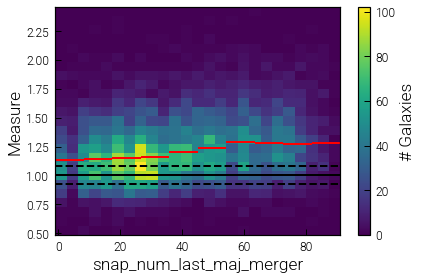

[0            NaN
1       1.785330
2       1.176091
3       1.431364
4       1.826075
          ...   
9485    1.838849
9486    1.591065
9487    1.380211
9488    1.763428
9489    1.113943
Name: snap_num_last_maj_merger, Length: 9490, dtype: float64] contains non-finite values.


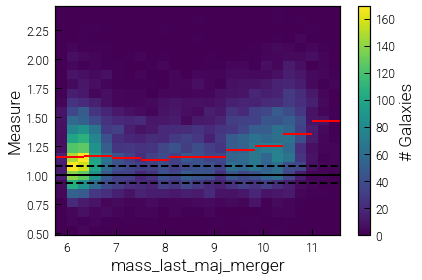

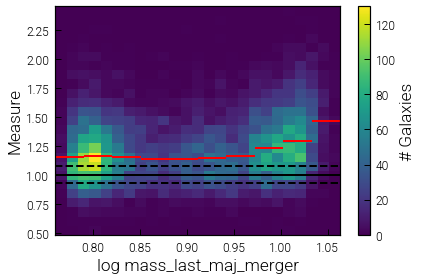

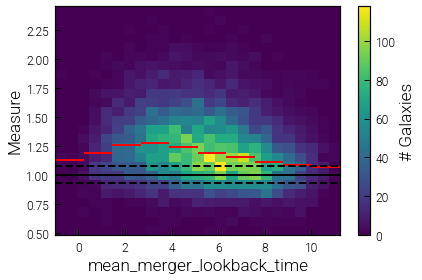

[0       0.776826
1       0.656894
2       0.605552
3       0.829534
4       0.616770
          ...   
9485    0.372713
9486    0.875926
9487    0.875052
9488    0.696880
9489    0.756616
Name: mean_merger_lookback_time, Length: 9490, dtype: float64] contains non-finite values.


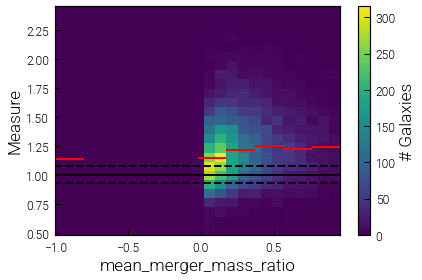

[0      -1.185917
1      -0.045866
2      -0.967425
3      -0.394502
4      -0.369745
          ...   
9485   -0.301058
9486   -0.508251
9487   -0.809103
9488   -0.212518
9489   -1.096548
Name: mean_merger_mass_ratio, Length: 9490, dtype: float64] contains non-finite values.


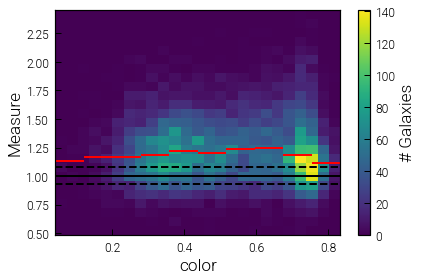

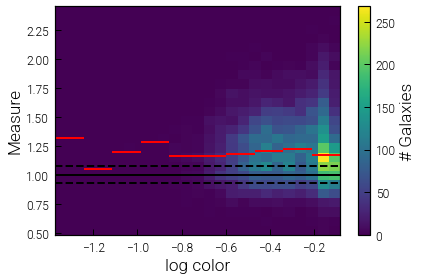

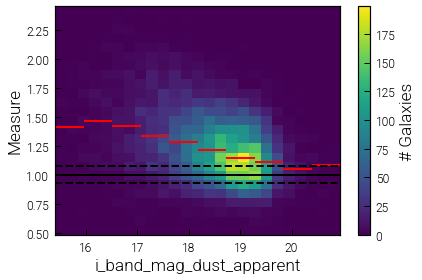

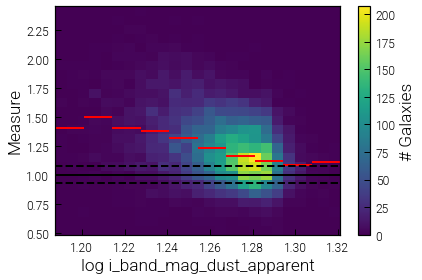

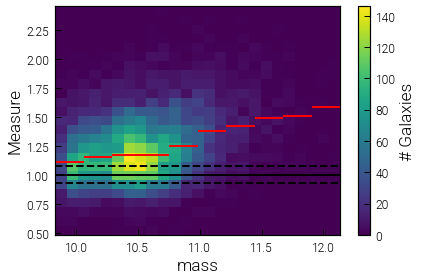

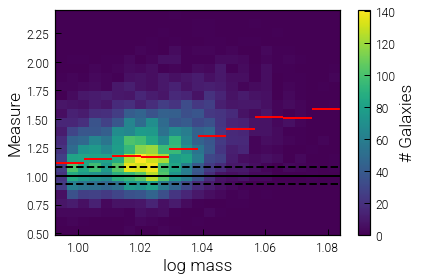

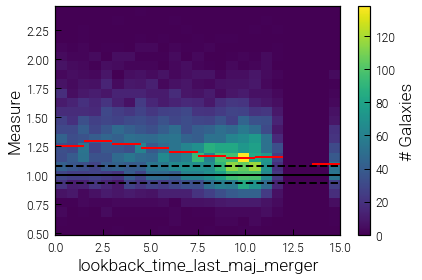

[0       1.176091
1       0.634333
2       1.012145
3       0.911109
4       0.510109
          ...   
9485    0.325009
9486    0.863426
9487    0.957573
9488    0.671290
9489    0.971476
Name: lookback_time_last_maj_merger, Length: 9490, dtype: float64] contains non-finite values.


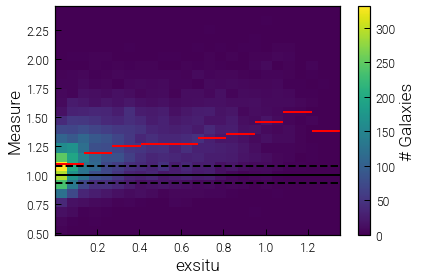

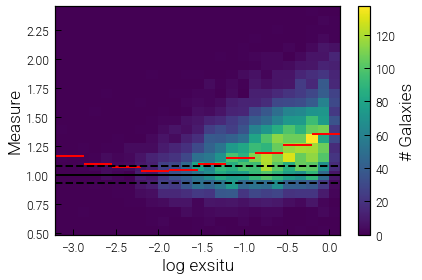

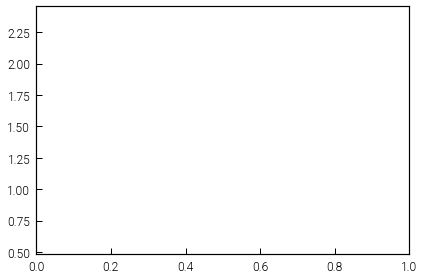

In [61]:
from scipy import stats

for label in df.columns.values:
    try:
        
        bin_statistic, bin_edges, binnumber = stats.binned_statistic(df_TNG100_0[label], measure_HSC, statistic='median', bins=10)
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2
        
        plt.hist2d(df_TNG100_0[label], measure_HSC, bins=25)
        plt.hlines(bin_statistic, bin_edges[:-1], bin_edges[1:], colors='r', lw=2)
        plt.plot([bin_edges[0], bin_edges[-1]], [mean_TNG, mean_TNG], 'k', lw=2)
        plt.plot([bin_edges[0], bin_edges[-1]], [lower_TNG, lower_TNG], 'k--', lw=2)
        plt.plot([bin_edges[0], bin_edges[-1]], [upper_TNG, upper_TNG], 'k--', lw=2)
        plt.colorbar(label='# Galaxies')
        plt.xlabel(label)
        plt.ylabel('Measure')
        plt.show()
        
        bin_statistic, bin_edges, binnumber = stats.binned_statistic(np.log10(df_TNG100_0[label]), measure_HSC, statistic='median', bins=10)
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2
        
        plt.hist2d(np.log10(df_TNG100_0[label]), measure_HSC, bins=25)
        plt.hlines(bin_statistic, bin_edges[:-1], bin_edges[1:], colors='r', lw=2)
        plt.plot([bin_edges[0], bin_edges[-1]], [mean_TNG, mean_TNG], 'k', lw=2)
        plt.plot([bin_edges[0], bin_edges[-1]], [lower_TNG, lower_TNG], 'k--', lw=2)
        plt.plot([bin_edges[0], bin_edges[-1]], [upper_TNG, upper_TNG], 'k--', lw=2)
        plt.colorbar(label='# Galaxies')
        plt.xlabel('log ' + label)
        plt.ylabel('Measure')
        plt.show()
        
        plt.ylim(min_HSC, max_HSC)
        
    except Exception as e:
        print(e)

from scipy import stats

for label in df.columns.values:
    try:
        bin_statistic, bin_edges, binnumber = stats.binned_statistic(df_TNG100_0[label], measure_HSC, statistic='mean', bins=10)
        
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2
        
        plt.title(label)
        plt.hlines(bin_statistic, bin_edges[:-1], bin_edges[1:], colors='g', lw=2)
        #plt.ylim(0,0.4)
        plt.show()
        
    except:
        pass

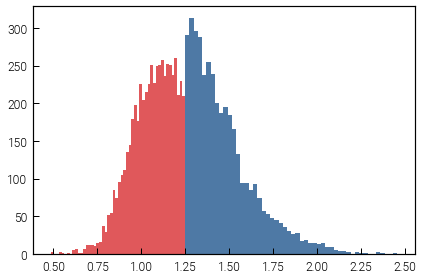

In [45]:
#quantile = np.quantile(measure, 0.9)
mask = measure_HSC > 1.25

plt.hist(measure_HSC[~mask], bins=50)
plt.hist(measure_HSC[mask], bins=50)

plt.show()

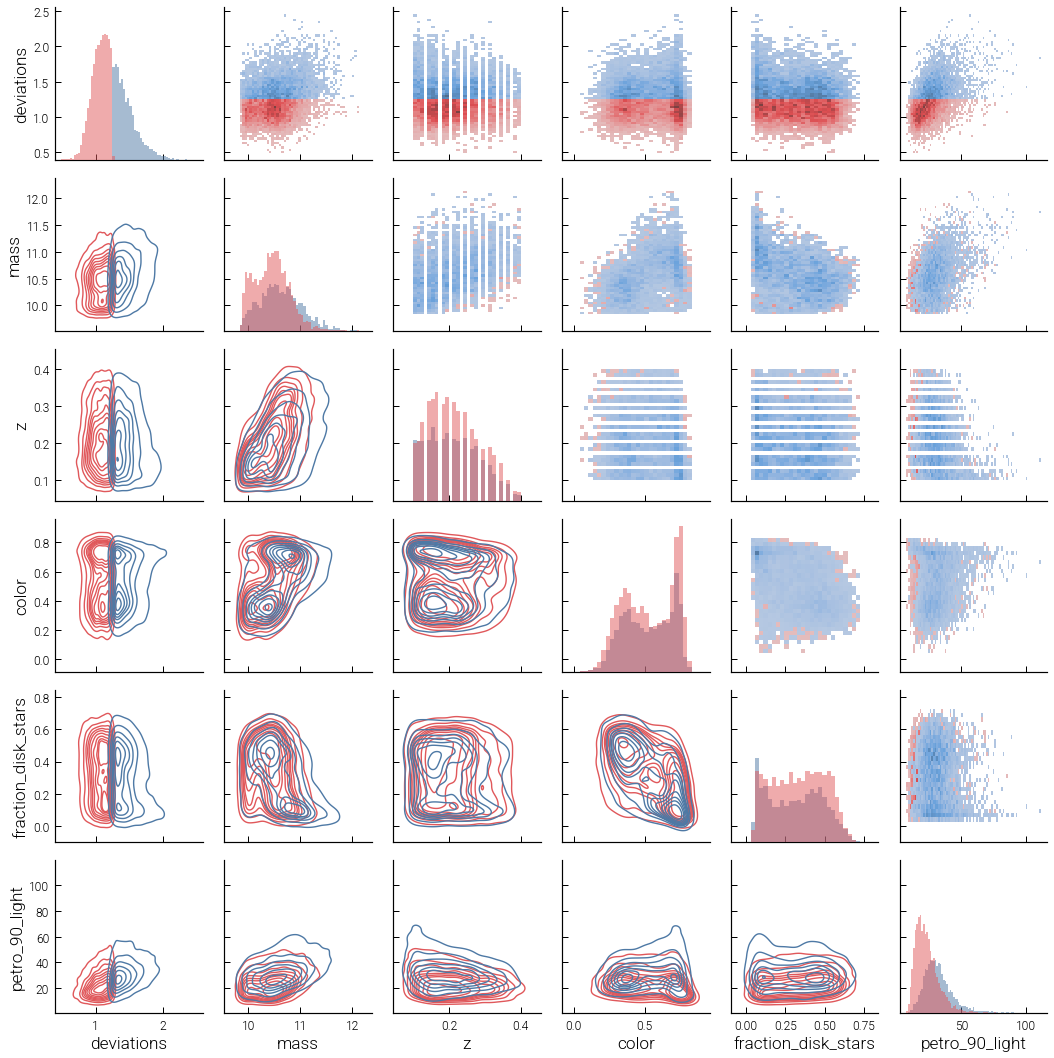

In [46]:
import seaborn as sns
d = {'high_deviation': mask, 'deviations': measure_HSC, 'mass': df_TNG100_0['mass'], 'z': df_TNG100_0['z'], 'color': df_TNG100_0['color'], 'fraction_disk_stars': df_TNG100_0['fraction_disk_stars'], 'petro_90_light': df_TNG100_0['petro_90_light']}
g = sns.PairGrid(pd.DataFrame(d), hue="high_deviation")
g.map_diag(sns.histplot)
g.map_lower(sns.kdeplot)
g.map_upper(sns.histplot)